# Preproccesing

## Import libraries

In [100]:
import numpy as np
from sklearn.metrics import r2_score
import scipy as sp
from seaborn_qqplot import pplot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.optimize import least_squares
import math as m
import statsmodels.api as sm
from scipy import stats
from pomegranate import *
import bamt
import bamt.Preprocessors as pp
from sklearn import preprocessing
import bamt.Networks as Nets
from sklearn.tree import DecisionTreeClassifier
from pgmpy.estimators import K2Score
from pgmpy.estimators import PC, ExhaustiveSearch
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG
import networkx as nx
from pgmpy.independencies import Independencies
from pgmpy.sampling.Sampling import BayesianModelSampling
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models.BayesianNetwork import BayesianNetwork
from sklearn.preprocessing import MinMaxScaler
from bamt.Nodes import *
#from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign

## Import & select data

In [2]:
%%time
df = pd.read_csv("D:/data.csv", low_memory=False).drop("traf", axis=1).dropna()
df = df.reset_index()

Wall time: 12.1 s


## Univariate parametric distributions

In [3]:
N = int(1+3.32*np.log(len(df)))
stat = "density"
kde = False

### Price -> normal distribution  (params from MLE)

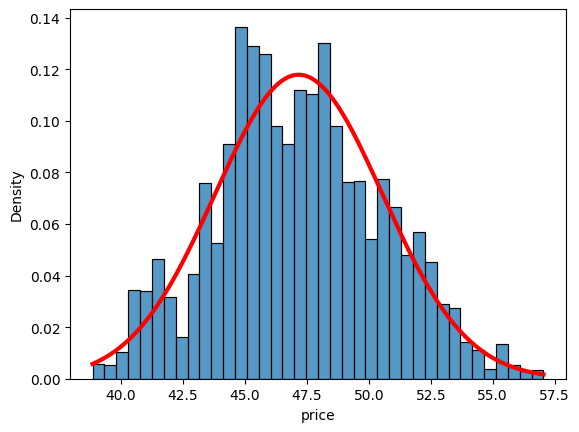

In [388]:
mu = np.mean(df['price'])
sigma = np.std(df['price'])
dist = stats.norm(loc=mu, scale=sigma)
sns.histplot(df['price'], bins=N, stat="density", kde=False)
x = np.arange(df['price'].min(),df['price'].max(), 0.001)
plt.plot(x, dist.pdf(x), "red", lw=3)

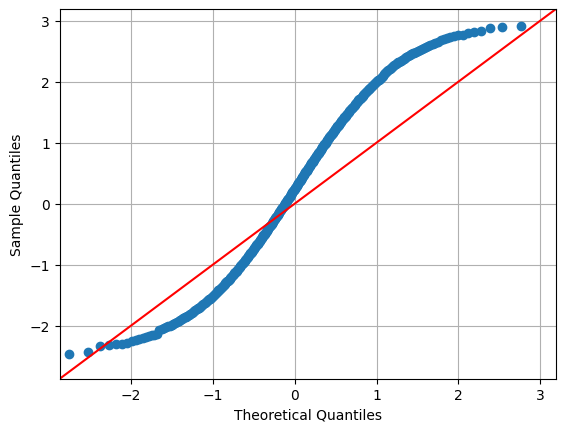

In [396]:
q = (np.sort(np.array(list(df['price'].value_counts().index))).reshape(-1) - mu)/sigma
fig = sm.qqplot(q, stats.norm, line='45')
plt.grid()
plt.show()

### Volume -> beta distribultion (params from MLE)

In [4]:
def beta_mle(x):
    x = x[x>0]
    N = len(x)
    G1 = np.prod(x**(1/N))
    G2 = np.prod((1-x)**(1/N))
    a = 0.5 + G1/(2*(1 - G1 - G2))
    b = 0.5 + G2/(2*(1 - G1 - G2))
    return a, b

In [5]:
a, b = beta_mle(df['volume'])
a, b

(1.277701886361419, 9.339272832316066)

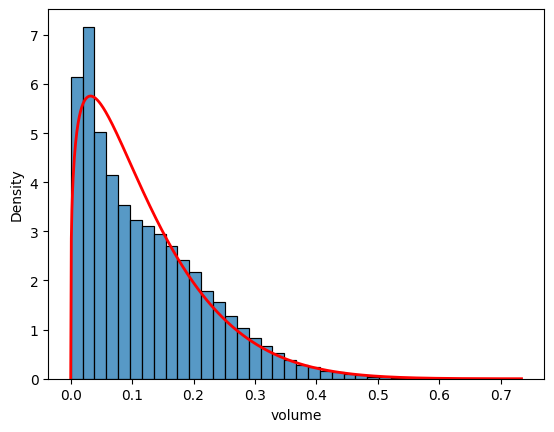

In [6]:
dist = stats.beta(a, b)
x = np.arange(0, df['volume'].max(), 0.001)
sns.histplot(df['volume'], bins=N, stat=stat, kde=kde)
plt.plot(x, dist.pdf(x), "red", lw=2)

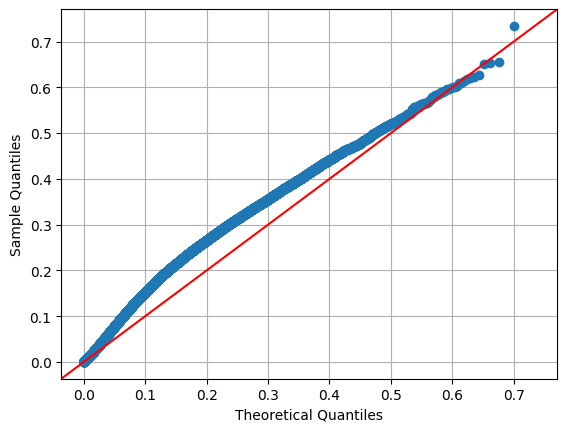

In [387]:
q = np.sort(np.array(list(df['volume'].value_counts().index))).reshape(-1)
fig = sm.qqplot(q, stats.beta, distargs=(a, b, ), line='45')
plt.grid()
plt.show()

### Profit -> gamma (params from MLE)

In [11]:
def gamma_mle(x):
    x = x[x>0]
    N = len(x)
    k = N*np.sum(x)/(N*np.sum(x*np.log(x)) - np.sum(x)*np.sum(np.log(x)))
    scale = 1/N**2 * (N*np.sum(x*np.log(x)) - np.sum(x)*np.sum(np.log(x)))
    #return k, scale
    return (k - 1/N*(3*k - 2/3*k/(1+k) - 4/5*k/(1+k)**2)), N/(N-1)*scale

In [12]:
k, sc = gamma_mle(df['profit'])
k, sc

(1.2282789409609849, 1818.0312457817474)

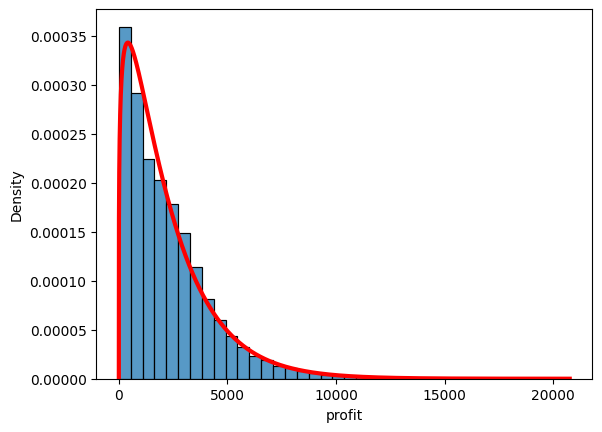

In [13]:
dist = stats.gamma(k, scale=sc)
x = np.arange(0, df['profit'].max())
sns.histplot(df['profit'], bins=N, stat=stat, kde=kde)
plt.plot(x, dist.pdf(x), "red", lw=3)

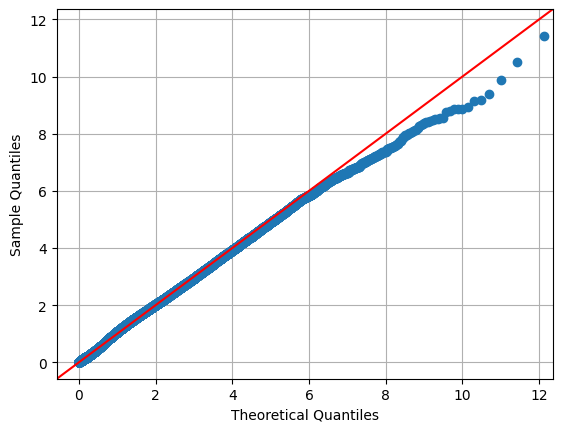

In [270]:
q = np.sort(np.array(list(df['profit'].value_counts().index))).reshape(-1)/sc
fig = sm.qqplot(q, stats.gamma, distargs=(k,), line='45')
plt.grid()
plt.show()

# Sampling

## Inverse Transform Sampling

### Price

In [73]:
def ITS1(n_samples, mu, dev):
    y = np.random.uniform(0, 1, n_samples)
    return sp.special.erfinv(2*y-1)*dev*m.sqrt(2) + mu

In [74]:
X = ITS1(100000, mu=np.mean(df['price']), dev=np.std(df['price']))

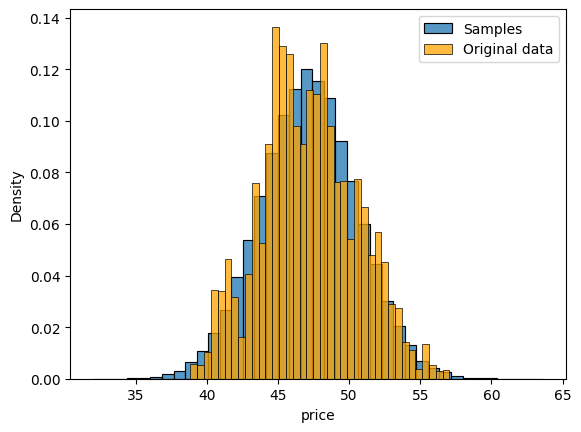

In [76]:
sns.histplot(X, bins=int(1+3.32*np.log(len(X))), stat='density', kde=False, label="Samples")
sns.histplot(df['price'], bins=N, stat="density", kde=False, label= "Original data", color='orange')
plt.legend()

### Volume

In [397]:
def ITS2(n_samples, a, b):
    y = np.random.uniform(0, 1, n_samples)
    return sp.special.betaincinv(a,b,y)

In [398]:
X = ITS2(100000, a=1.277701886361419, b=9.339272832316066)

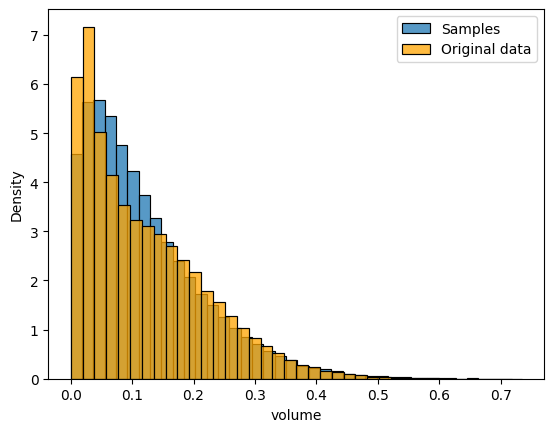

In [399]:
sns.histplot(X, bins=int(1+3.32*np.log(len(X))), stat='density', kde=False, label="Samples")
sns.histplot(df['volume'], bins=N, stat="density", kde=False, label= "Original data", color='orange')
plt.legend()

### Profit

In [146]:
def ITS3(n_samples, k, scale):
    y = np.random.uniform(0, 1, n_samples)
    return stats.gamma(k, scale=scale).ppf(y)

In [147]:
X = ITS3(100000, k=k, scale=sc)

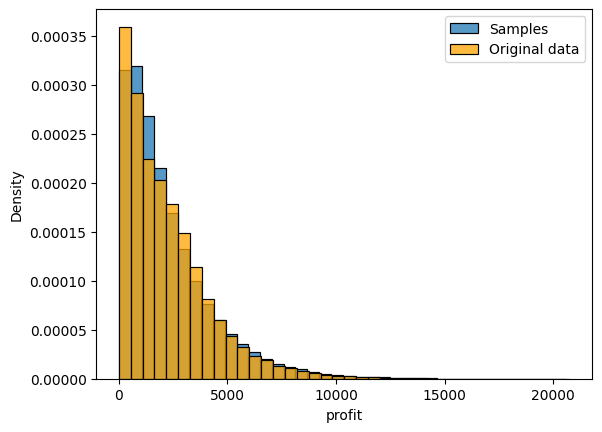

In [149]:
sns.histplot(X, bins=N, stat="density", kde=False, label="Samples")
sns.histplot(df['profit'], bins=N, stat='density', kde=False, label= "Original data", color='orange')
plt.legend()

## Accept-Reject Sampling

### Price

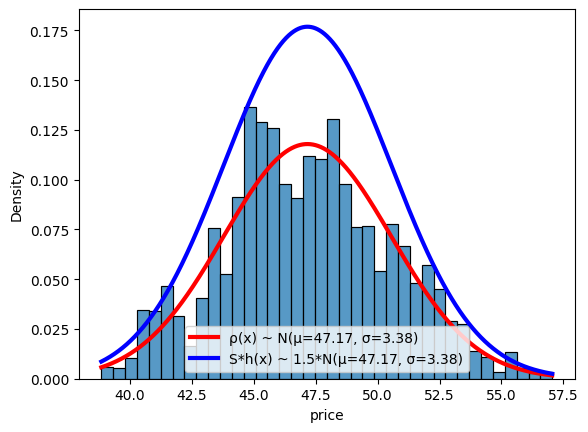

In [59]:
dist = stats.norm(loc=np.mean(df['price']), scale=np.std(df['price']))
sns.histplot(df['price'], bins=N, stat="density", kde=False)
x = np.arange(df['price'].min(),df['price'].max(), 0.001)
plt.plot(x, dist.pdf(x), "red", lw=3, label="ρ(x) ~ N(μ=47.17, σ=3.38)")
dist2 = stats.norm(loc=np.mean(df['price']), scale=np.std(df['price']))
plt.plot(x, 1.5*dist2.pdf(x), "blue", lw=3, label="S*h(x) ~ 1.5*N(μ=47.17, σ=3.38)")
plt.legend()

In [68]:
def ARS1(n_samples, S=1.5, threshold=1e+6):
    dist = stats.norm(loc=np.mean(df['price']), scale=np.std(df['price']))
    dist2 = stats.norm(loc=np.mean(df['price']), scale=np.std(df['price']))
    res = []
    n_iters = 1
    while True:
        x = dist2.rvs()
        if np.random.random() < dist.pdf(x)/(S*dist2.pdf(x)):
            res.append(x)
        if len(res) == n_samples:
            break
        n_iters += 1
        if n_iters >= threshold:
            return None
    return {"Samples": res, "n_iters": n_iters, "Eff": n_samples/n_iters}

In [84]:
res = ARS1(100000, S=1.5)
res

{'Samples': [49.24796243717726,
  51.3926880256274,
  51.70855496828596,
  50.069471110391575,
  51.223587043357824,
  48.51034442052078,
  46.38861111697431,
  53.808520022827494,
  52.21924729107562,
  39.27150114567127,
  51.834074706089154,
  45.29516097169312,
  48.02657723920684,
  43.72604638878806,
  53.29692009433872,
  48.647027848040096,
  48.6687245017797,
  46.05683102666743,
  45.987137781427464,
  47.23620739317015,
  50.901448961597694,
  40.802497838597816,
  49.83082160565597,
  49.15624288889841,
  50.17135431154534,
  44.99087467413325,
  47.54838561723283,
  44.383011900707885,
  50.44887016490479,
  48.516083107409536,
  46.359991561260784,
  49.01023096117238,
  48.69871734107355,
  43.39738122415199,
  50.12513581715267,
  44.86035305856084,
  46.65127974019292,
  48.345871869565975,
  45.24169445854123,
  49.87632763496379,
  50.96234747591593,
  48.334690806697985,
  42.68735764505387,
  51.70505858524642,
  46.599439069706435,
  46.10449998955657,
  49.256900

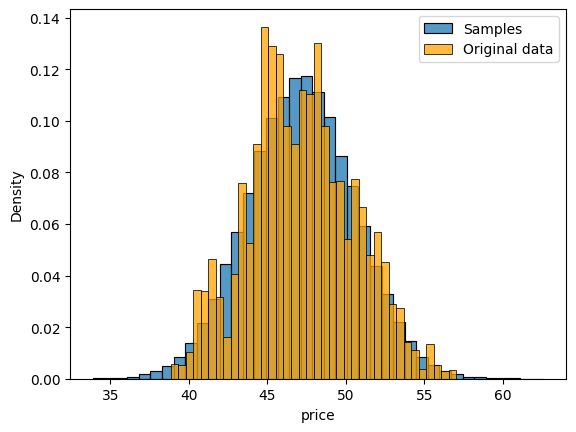

In [90]:
sns.histplot(res['Samples'], bins=int(1+3.32*np.log(len(res['Samples']))), stat=stat, kde=kde, label="Samples")
sns.histplot(df['price'], bins=N, stat=stat, kde=kde, label= "Original data", color='orange')
plt.legend()

### Volume

In [415]:
def expon(x, a):
    return a*np.exp(-a*x)

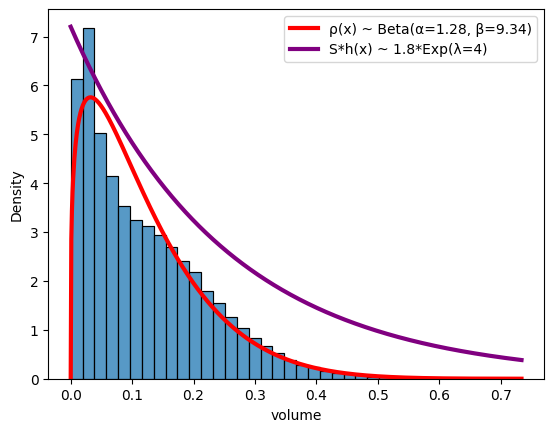

In [444]:
dist = stats.beta(a=1.277701886361419, b=9.339272832316066)
sns.histplot(df['volume'], bins=N, stat=stat, kde=kde)
x = np.arange(df['volume'].min(),df['volume'].max(), 0.001)
plt.plot(x, dist.pdf(x), "red", lw=3, label="ρ(x) ~ Beta(α=1.28, β=9.34)")
plt.plot(x, 1.8*expon(x, 4), "purple", lw=3, label="S*h(x) ~ 1.8*Exp(λ=4)")
plt.legend()

In [431]:
def ARS2(n_samples, S=1.8, threshold=2e+6):
    dist = stats.beta(a=1.277701886361419, b=9.339272832316066)
    res = []
    n_iters = 1
    lmb = 4
    while True:
        x = np.random.exponential(scale=1/lmb)
        if np.random.random() < dist.pdf(x)/(S*expon(x, lmb)):
            res.append(x)
        if len(res) == n_samples:
            break
        n_iters += 1
        if n_iters >= threshold:
            return None
    return {"Samples": res, "n_iters": n_iters, "Eff": n_samples/n_iters}

In [432]:
res = ARS2(100000)
res

{'Samples': [0.3745637932032663,
  0.30333278764070415,
  0.05115763369507793,
  0.05832439451539749,
  0.033933628263694726,
  0.21262780995781852,
  0.16842698373789108,
  0.17548781171741876,
  0.030916416575839246,
  0.2082018023285275,
  0.12867469529134892,
  0.3268120120374701,
  0.014141262218440268,
  0.13804516012025853,
  0.11606964488907986,
  0.019184216473956055,
  0.00795246508960892,
  0.20064964760306192,
  0.18266046394310845,
  0.03714366850879466,
  0.20069917027896383,
  0.05224466901710117,
  0.05731011175978598,
  0.12518302528883185,
  0.14796419823761872,
  0.04153639287881733,
  0.14898644541406098,
  0.08289888234345988,
  0.04930998254254228,
  0.188496627017392,
  0.05453986093398995,
  0.12024128409463589,
  0.04989246599249539,
  0.03153970897465317,
  0.2140992752854125,
  0.08928053361853008,
  0.0643992619105568,
  0.20327469938642717,
  0.021306429989564828,
  0.1058416095505252,
  0.3516657217666809,
  0.08628856462258679,
  0.16736376868043834,
  0.

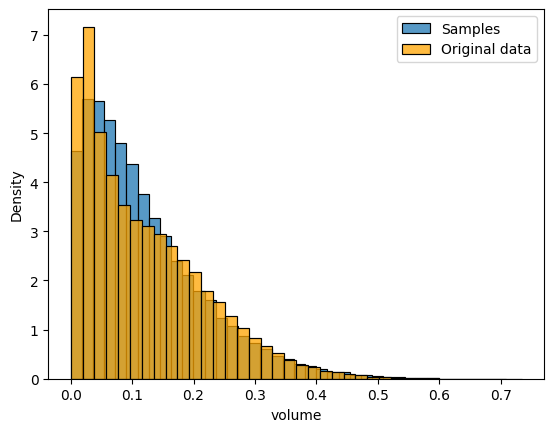

In [433]:
sns.histplot(res['Samples'], bins=int(1+3.32*np.log(len(res['Samples']))), stat=stat, label="Samples")
sns.histplot(df['volume'], bins=N, stat=stat, kde=kde, label= "Original data", color='orange')
plt.legend()

### Profit

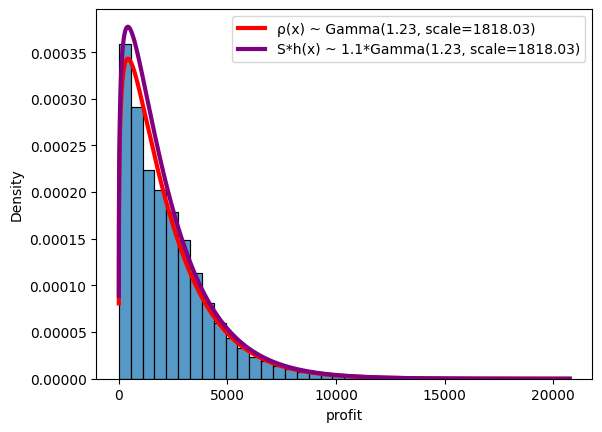

In [446]:
dist = stats.gamma(k, scale=sc)
dist2 = stats.gamma(k, scale=sc)
x = df['profit']
sns.histplot(x, bins=N, stat=stat, kde=kde)
x = np.arange(x.min(),x.max(), 0.1)
plt.plot(x, dist.pdf(x), "red", lw=3, label="ρ(x) ~ Gamma(1.23, scale=1818.03)")
plt.plot(x, 1.1*dist2.pdf(x), "purple", lw=3, label="S*h(x) ~ 1.1*Gamma(1.23, scale=1818.03)")
plt.legend()

In [438]:
def ARS3(n_samples, S=1.1, threshold=2e+6):
    dist = stats.gamma(k, scale=sc)
    res = []
    n_iters = 1
    dist2 = stats.gamma(k, scale=sc)
    while True:
        x = dist2.rvs()
        if np.random.random() < dist.pdf(x)/(S*dist2.pdf(x)):
            res.append(x)
        if len(res) == n_samples:
            break
        n_iters += 1
        if n_iters >= threshold:
            return None
    return {"Samples": res, "n_iters": n_iters, "Eff": n_samples/n_iters}

In [441]:
res = ARS3(100000)
res

{'Samples': [466.3600108148331,
  4398.67372589285,
  85.31524183367738,
  1026.430967472142,
  3498.7258868508034,
  30.053257521712172,
  831.2877859363026,
  4702.464803505469,
  489.6333885694907,
  1731.0156725153802,
  1720.6089461841325,
  1906.0087952684946,
  175.47914057174665,
  385.89299495867397,
  34.05324558207046,
  643.3640804891648,
  6116.693121072853,
  3410.0742129506175,
  2393.9286613718964,
  1698.1540541666398,
  3487.5385218125202,
  108.26192955383148,
  2086.2461867346397,
  1395.5106468269835,
  41.67394072448909,
  2806.806237905005,
  7101.815793226224,
  5059.399559729898,
  1696.7728620098615,
  1069.4429983941877,
  8607.595051099524,
  439.10923554585,
  712.41028966708,
  1748.2902513191095,
  6007.938583201287,
  2163.5122846136687,
  35.9271102926678,
  3914.3631230317606,
  5202.649506314499,
  1140.588475214681,
  275.813292318516,
  2287.8965296496604,
  3710.974838110608,
  3571.376121734371,
  551.9888723590283,
  1293.1978319603647,
  2621.63

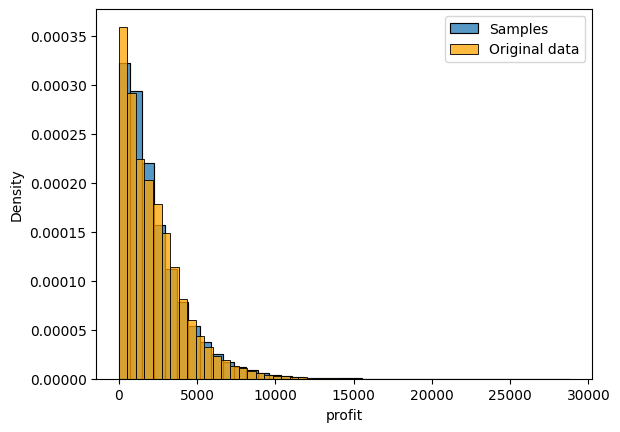

In [442]:
sns.histplot(res['Samples'], bins=int(1+3.32*np.log(len(res['Samples']))), stat=stat, label="Samples")
sns.histplot(df['profit'], bins=N, stat=stat, kde=kde, label= "Original data", color='orange')
plt.legend()

# Relations estimation

In [17]:
targets = ["price","volume","profit"]
predictors = ["product_id",'cost','trend','discount_bonusy_rub','big_competitor_mean_price_relative',
              'not_big_competitor_mean_price_relative','cold']

In [28]:
vals = list(df["product_id"].unique())
d = {}
for i, val in enumerate(vals):
    d[val] = i
df2 = df.replace({"product_id": d})

In [29]:
def corrSp(df, n, feats, a=0.05):
    corr = df[feats].corr("spearman")
    t = stats.t(n-2).ppf(1-a)
    S = t*(n - 2 + t*t)**(-1/2)
    return corr, S

In [31]:
dfcorr, S = corrSp(df2, len(df2), predictors+targets, a=0.05)
dfcorr.to_excel("dfcorr2.xlsx")
print(S)
dfcorr

0.005382302602626512


,product_id,cost,trend,discount_bonusy_rub,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative,cold,price,volume,profit
product_id,1.000000,0.110341,-0.177234,-0.094308,-0.067055,0.159294,-0.097177,0.348040,-0.152583,-0.055393
cost,0.110341,1.000000,-0.167184,-0.117123,-0.060609,-0.219010,-0.211363,0.409041,-0.123896,-0.172241
trend,-0.177234,-0.167184,1.000000,0.387938,-0.096691,-0.167025,-0.082128,-0.233128,0.492547,0.452264
discount_bonusy_rub,-0.094308,-0.117123,0.387938,1.000000,-0.038060,-0.080975,-0.017766,-0.128467,0.882379,0.860110
big_competitor_mean_price_relative,-0.067055,-0.060609,-0.096691,-0.038060,1.000000,0.373708,-0.051479,0.036944,-0.001780,0.036834
not_big_competitor_mean_price_relative,0.159294,-0.219010,-0.167025,-0.080975,0.373708,1.000000,0.179929,-0.100463,-0.111246,-0.102828
cold,-0.097177,-0.211363,-0.082128,-0.017766,-0.051479,0.179929,1.000000,0.095894,-0.046953,-0.010452
price,0.348040,0.409041,-0.233128,-0.128467,0.036944,-0.100463,0.095894,1.000000,-0.178078,0.000489
volume,-0.152583,-0.123896,0.492547,0.882379,-0.001780,-0.111246,-0.046953,-0.178078,1.000000,0.964467
profit,-0.055393,-0.172241,0.452264,0.860110,0.036834,-0.102828,-0.010452,0.000489,0.964467,1.000000


In [32]:
dfcorr, S = corrSp(df2, 1e+2, predictors+targets, a=0.05)
print(S)
dfcorr

0.16542979583644515


,product_id,cost,trend,discount_bonusy_rub,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative,cold,price,volume,profit
product_id,1.000000,0.110341,-0.177234,-0.094308,-0.067055,0.159294,-0.097177,0.348040,-0.152583,-0.055393
cost,0.110341,1.000000,-0.167184,-0.117123,-0.060609,-0.219010,-0.211363,0.409041,-0.123896,-0.172241
trend,-0.177234,-0.167184,1.000000,0.387938,-0.096691,-0.167025,-0.082128,-0.233128,0.492547,0.452264
discount_bonusy_rub,-0.094308,-0.117123,0.387938,1.000000,-0.038060,-0.080975,-0.017766,-0.128467,0.882379,0.860110
big_competitor_mean_price_relative,-0.067055,-0.060609,-0.096691,-0.038060,1.000000,0.373708,-0.051479,0.036944,-0.001780,0.036834
not_big_competitor_mean_price_relative,0.159294,-0.219010,-0.167025,-0.080975,0.373708,1.000000,0.179929,-0.100463,-0.111246,-0.102828
cold,-0.097177,-0.211363,-0.082128,-0.017766,-0.051479,0.179929,1.000000,0.095894,-0.046953,-0.010452
price,0.348040,0.409041,-0.233128,-0.128467,0.036944,-0.100463,0.095894,1.000000,-0.178078,0.000489
volume,-0.152583,-0.123896,0.492547,0.882379,-0.001780,-0.111246,-0.046953,-0.178078,1.000000,0.964467
profit,-0.055393,-0.172241,0.452264,0.860110,0.036834,-0.102828,-0.010452,0.000489,0.964467,1.000000


# Bayesian network

## Preprocessing

In [272]:
def plot_graph(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(15.4*0.5,16*0.5))
    nx.draw(G, nx.layout.spiral_layout(G), with_labels=True,font_weight='bold', font_size=6)

In [45]:
def eval(data, feat, preds, labels=['Correlations','K2-Score']):
    dfscores = pd.DataFrame(index=['RMSE','MAE','R2'], columns=['Correlations','K2-Score'])
    dfeval = pd.DataFrame()
    dfeval['target'] = data[feat]
    for it, pred in enumerate(preds):
        dfeval[labels[it]] = np.array(pred[feat])   
    dfeval = dfeval.dropna()
    for label in labels:
        dfscores.loc['RMSE', label] = np.sqrt(np.sum((dfeval['target'] - dfeval[label])**2)/len(dfeval))
        dfscores.loc['MAE', label] = np.sum(np.abs(dfeval['target'] - dfeval[label]))/len(dfeval)
        dfscores.loc['R2', label] = r2_score(dfeval['target'], dfeval[label])
    for label in labels:
        plt.figure()
        pplot(dfeval, x="target", y=label, kind='qq', height=6, aspect=16/15.4, display_kws={"identity":True})
        plt.grid()
    plt.show()
    return dfeval, dfscores

In [5]:
def create_all_combinations(feats, to_omit=[]):
    out = []
    #out2 = []
    for i in tqdm(range(1,len(feats))):
        for j in range(i):
            out.append([feats[j],feats[i]])
            #out2.append((j, i))
    if len(to_omit) > 0:
        for edge in to_omit:
            out.remove(edge)
    return out#, out2

In [6]:
N = int(1+3.32*np.log(len(df)))
targets = ["price","volume","profit"]
predictors = ["product_id",'cold','cost','trend','discount_bonusy_rub','big_competitor_mean_price_relative',
              'not_big_competitor_mean_price_relative']
vals = list(df["product_id"].unique())
d = {}
for i, val in enumerate(vals):
    d[val] = i
df = df.replace({"cold": {0: "F", 1: "T"}})
df2 = df.replace({"product_id": d})
df2 = df.replace({"cold": {"F": 0, "T": 1}})
df2 = df2.replace({"product_id": d})
df2 = df2[predictors+targets]
df2.sample(4)

,product_id,cold,cost,trend,discount_bonusy_rub,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative,price,volume,profit
81022,2,0,35.422128,6709.993620,60.66,0.982515,0.997378,49.45,0.033591,709.108930
2857,1,1,33.129488,5845.480408,159.99,0.986285,1.015956,40.75,0.147536,1691.143981
7724,1,0,35.574397,6179.548649,222.50,0.987431,0.980652,41.90,0.275630,2622.405411
36248,2,0,34.220643,4541.101330,547.36,0.976206,0.987111,45.95,0.247498,4366.370284


## Target = price

### Preprocessing

In [258]:
target = ["price"]
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
p1 = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p1.apply(df[predictors+target])
#discretized_data, est = p1.apply(df[ ['product_id','cold','price','cost']])
info1 = p1.info
info1

{'types': {'product_id': 'disc',
  'cold': 'disc',
  'cost': 'cont',
  'trend': 'cont',
  'discount_bonusy_rub': 'cont',
  'big_competitor_mean_price_relative': 'cont',
  'not_big_competitor_mean_price_relative': 'cont',
  'price': 'cont'},
 'signs': {'cost': 'pos',
  'trend': 'pos',
  'discount_bonusy_rub': 'pos',
  'big_competitor_mean_price_relative': 'pos',
  'not_big_competitor_mean_price_relative': 'pos',
  'price': 'pos'}}

### Learning (using correlations)

In [24]:
nodes = []
for feat in predictors+target:
    if feat in ['product_id','cold']:
        nodes.append(DiscreteNode(feat))
    else:
        nodes.append(ConditionalGaussianNode(feat))
nodes

[product_id,
 cold,
 cost,
 trend,
 discount_bonusy_rub,
 big_competitor_mean_price_relative,
 not_big_competitor_mean_price_relative,
 price]

In [25]:
bn11 = Nets.HybridBN(has_logit=False, use_mixture=False) #not working when use_mixture=True
edges = create_all_combinations(predictors+target)
bn11.set_structure(info1, nodes, edges[:])

  0%|          | 0/7 [00:00<?, ?it/s]

In [26]:
bn11.get_info()

,name,node_type,data_type,parents,parents_types
0,product_id,Discrete,disc,[],[]
1,cold,Discrete,disc,[product_id],[disc]
2,cost,ConditionalGaussian,cont,"[product_id, cold]","[disc, disc]"
3,trend,ConditionalGaussian,cont,"[cost, product_id, cold]","[cont, disc, disc]"
4,discount_bonusy_rub,ConditionalGaussian,cont,"[cost, trend, product_id, cold]","[cont, cont, disc, disc]"
5,big_competitor_mean_price_relative,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, product_id,...","[cont, cont, cont, disc, disc]"
6,not_big_competitor_mean_price_relative,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, big_competi...","[cont, cont, cont, cont, disc, disc]"
7,price,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, big_competi...","[cont, cont, cont, cont, cont, disc, disc]"


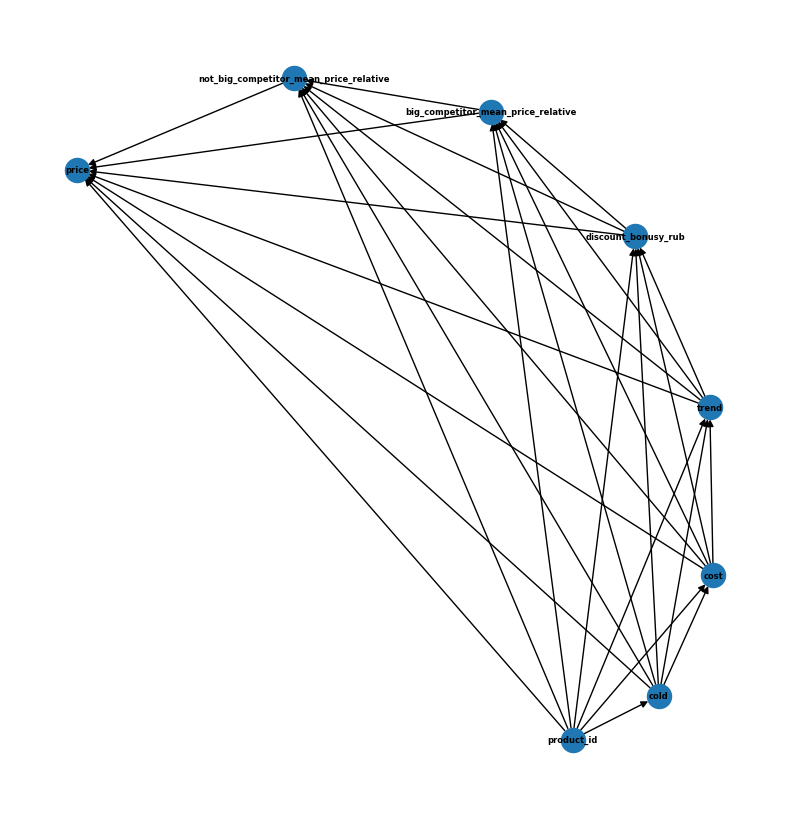

In [261]:
plot_graph(bn11.edges)

In [28]:
bn11.fit_parameters(df2[predictors+target])

In [29]:
val_pred11 = bn11.predict(df2[predictors], 5)

100%|██████████| 93395/93395 [03:09<00:00, 492.34it/s]


### Learning (using K2-score)

In [8]:
bn12 = Nets.HybridBN(has_logit=False, use_mixture=False)
bn12.add_nodes(info1)
bn12.add_edges(discretized_data, scoring_function=('K2',K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [9]:
bn12.get_info()

,name,node_type,data_type,parents,parents_types
0,product_id,Discrete,disc,[],[]
1,cold,Discrete,disc,[product_id],[disc]
2,trend,ConditionalGaussian,cont,"[product_id, cold]","[disc, disc]"
3,price,ConditionalGaussian,cont,"[trend, product_id, cold]","[cont, disc, disc]"
4,not_big_competitor_mean_price_relative,ConditionalGaussian,cont,"[trend, price, product_id, cold]","[cont, cont, disc, disc]"
5,big_competitor_mean_price_relative,ConditionalGaussian,cont,"[trend, not_big_competitor_mean_price_relative...","[cont, cont, cont, disc, disc]"
6,cost,ConditionalGaussian,cont,"[trend, big_competitor_mean_price_relative, no...","[cont, cont, cont, cont, disc, disc]"
7,discount_bonusy_rub,ConditionalGaussian,cont,"[trend, big_competitor_mean_price_relative, no...","[cont, cont, cont, cont, disc]"


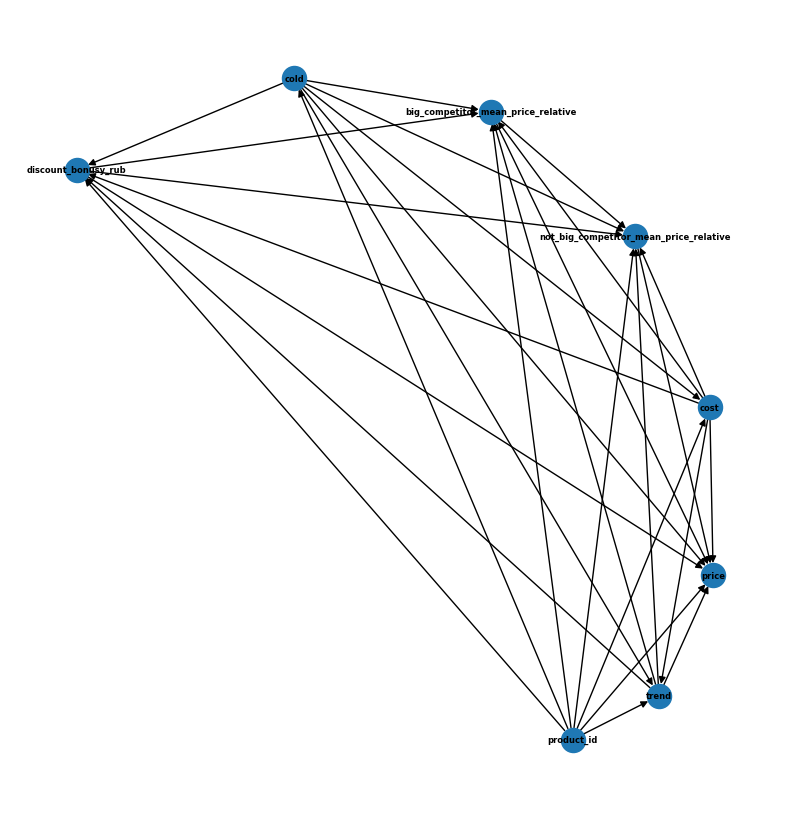

In [262]:
plot_graph(bn12.edges)

In [11]:
bn12.fit_parameters(df2[predictors+target])

In [12]:
val_pred12 = bn12.predict(df2[predictors], 5)

100%|██████████| 93395/93395 [03:03<00:00, 508.25it/s]


### Learning (using constrained-based approach)

In [159]:
est1 = PC(discretized_data[predictors+target])
predictors+target

['product_id',
 'cold',
 'cost',
 'trend',
 'discount_bonusy_rub',
 'big_competitor_mean_price_relative',
 'not_big_competitor_mean_price_relative',
 'price']

In [160]:
best_model1_ = est1.estimate(variant="stable", max_cond_vars=4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [161]:
list(best_model1_.edges)

[('big_competitor_mean_price_relative', 'price'),
 ('cost', 'price'),
 ('cost', 'big_competitor_mean_price_relative'),
 ('cost', 'cold'),
 ('cold', 'price'),
 ('cold', 'big_competitor_mean_price_relative'),
 ('trend', 'price'),
 ('trend', 'big_competitor_mean_price_relative'),
 ('trend', 'cold'),
 ('trend', 'cost'),
 ('trend', 'discount_bonusy_rub'),
 ('discount_bonusy_rub', 'price'),
 ('discount_bonusy_rub', 'big_competitor_mean_price_relative'),
 ('discount_bonusy_rub', 'cold'),
 ('discount_bonusy_rub', 'cost'),
 ('product_id', 'price'),
 ('product_id', 'big_competitor_mean_price_relative'),
 ('product_id', 'cold'),
 ('product_id', 'cost'),
 ('product_id', 'discount_bonusy_rub'),
 ('product_id', 'trend'),
 ('not_big_competitor_mean_price_relative', 'price'),
 ('not_big_competitor_mean_price_relative',
  'big_competitor_mean_price_relative'),
 ('not_big_competitor_mean_price_relative', 'cold'),
 ('not_big_competitor_mean_price_relative', 'cost'),
 ('not_big_competitor_mean_price_relat

In [165]:
nodes = []
for feat in predictors+target:
    if feat in ['product_id','cold']:
        nodes.append(DiscreteNode(feat))
    else:
        nodes.append(ConditionalGaussianNode(feat))
bn13 = Nets.HybridBN(has_logit=False, use_mixture=False) #not working when use_mixture=True
bn13.set_structure(info1, nodes, list(best_model1_.edges))
bn13.get_info()

,name,node_type,data_type,parents,parents_types
0,not_big_competitor_mean_price_relative,Gaussian,cont,[],[]
1,product_id,Discrete,disc,[not_big_competitor_mean_price_relative],[cont]
2,trend,ConditionalGaussian,cont,"[not_big_competitor_mean_price_relative, produ...","[cont, disc]"
3,discount_bonusy_rub,ConditionalGaussian,cont,"[trend, not_big_competitor_mean_price_relative...","[cont, cont, disc]"
4,cost,ConditionalGaussian,cont,"[trend, discount_bonusy_rub, not_big_competito...","[cont, cont, cont, disc]"
5,cold,Discrete,disc,"[cost, trend, discount_bonusy_rub, not_big_com...","[cont, cont, cont, cont, disc]"
6,big_competitor_mean_price_relative,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, not_big_com...","[cont, cont, cont, cont, disc, disc]"
7,price,ConditionalGaussian,cont,"[big_competitor_mean_price_relative, cost, tre...","[cont, cont, cont, cont, cont, disc, disc]"


In [166]:
bn13.plot("Output.html")

In [179]:
bn13.fit_parameters(df2[predictors+target].sample(25))

### Results

<Figure size 640x480 with 0 Axes>

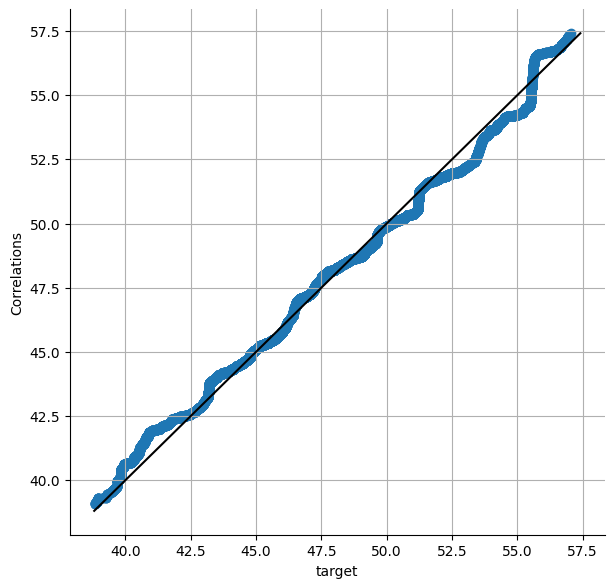

<Figure size 640x480 with 0 Axes>

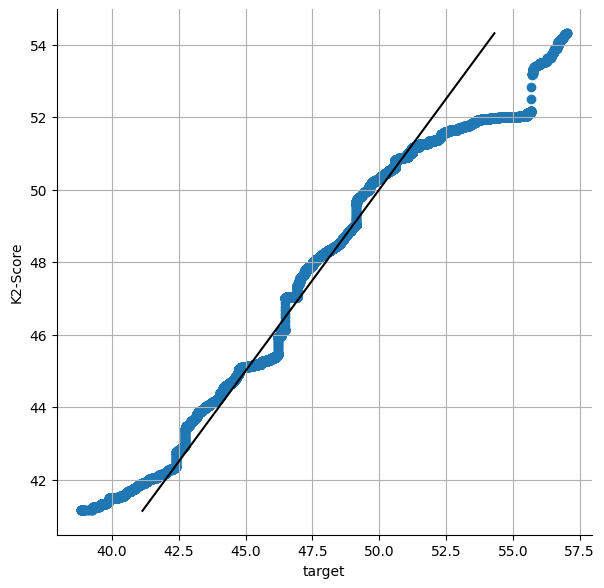

,Correlations,K2-Score
RMSE,1.237279,1.580352
MAE,0.990971,1.23908
R2,0.866286,0.781853


In [46]:
dfeval, dfscores = eval(df2, 'price', [val_pred11, val_pred12], labels=['Correlations','K2-Score'])
dfscores

## Target = volume

### Preprocessing

In [268]:
target = ["volume"]
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
p2 = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p2.apply(df[predictors+target])
info2 = p2.info
info2

{'types': {'product_id': 'disc',
  'cold': 'disc',
  'cost': 'cont',
  'trend': 'cont',
  'discount_bonusy_rub': 'cont',
  'big_competitor_mean_price_relative': 'cont',
  'not_big_competitor_mean_price_relative': 'cont',
  'volume': 'cont'},
 'signs': {'cost': 'pos',
  'trend': 'pos',
  'discount_bonusy_rub': 'pos',
  'big_competitor_mean_price_relative': 'pos',
  'not_big_competitor_mean_price_relative': 'pos',
  'volume': 'pos'}}

### Learning (using correlations)

In [269]:
nodes = []
for feat in predictors+target:
    if feat in ['product_id','cold']:
        nodes.append(DiscreteNode(feat))
    else:
        nodes.append(ConditionalGaussianNode(feat))
bn21 = Nets.HybridBN(has_logit=False, use_mixture=False) #not working when use_mixture=True
edges = create_all_combinations(predictors+target)
edges.remove(["big_competitor_mean_price_relative","volume"])
bn21.set_structure(info2, nodes, edges)
bn21.get_info()

  0%|          | 0/7 [00:00<?, ?it/s]

,name,node_type,data_type,parents,parents_types
0,product_id,Discrete,disc,[],[]
1,cold,Discrete,disc,[product_id],[disc]
2,cost,ConditionalGaussian,cont,"[product_id, cold]","[disc, disc]"
3,trend,ConditionalGaussian,cont,"[cost, product_id, cold]","[cont, disc, disc]"
4,discount_bonusy_rub,ConditionalGaussian,cont,"[cost, trend, product_id, cold]","[cont, cont, disc, disc]"
5,big_competitor_mean_price_relative,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, product_id,...","[cont, cont, cont, disc, disc]"
6,not_big_competitor_mean_price_relative,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, big_competi...","[cont, cont, cont, cont, disc, disc]"
7,volume,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, not_big_com...","[cont, cont, cont, cont, disc, disc]"


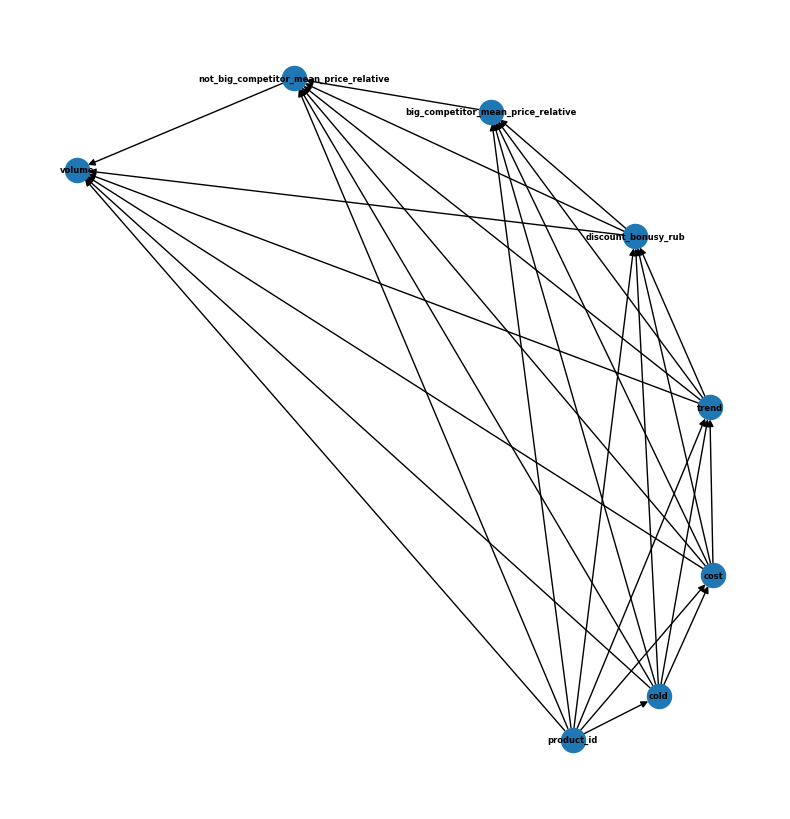

In [273]:
plot_graph(bn21.edges)

In [59]:
bn21.fit_parameters(df2[predictors+target])

In [60]:
val_pred21 = bn21.predict(df2[predictors], 5)

100%|██████████| 93395/93395 [03:20<00:00, 466.39it/s]


###  Learning (using K2-score)

In [61]:
bn22 = Nets.HybridBN()
bn22.add_nodes(info2)
bn22.add_edges(discretized_data, scoring_function=('K2',K2Score))
bn22.get_info()

  0%|          | 0/1000000 [00:00<?, ?it/s]

,name,node_type,data_type,parents,parents_types
0,product_id,Discrete,disc,[],[]
1,cold,Discrete,disc,[product_id],[disc]
2,trend,ConditionalGaussian,cont,"[product_id, cold]","[disc, disc]"
3,not_big_competitor_mean_price_relative,ConditionalGaussian,cont,"[trend, product_id, cold]","[cont, disc, disc]"
4,big_competitor_mean_price_relative,ConditionalGaussian,cont,"[trend, not_big_competitor_mean_price_relative...","[cont, cont, disc, disc]"
5,cost,ConditionalGaussian,cont,"[trend, big_competitor_mean_price_relative, no...","[cont, cont, cont, disc, disc]"
6,discount_bonusy_rub,ConditionalGaussian,cont,"[cost, trend, big_competitor_mean_price_relati...","[cont, cont, cont, cont, disc]"
7,volume,ConditionalGaussian,cont,"[trend, discount_bonusy_rub, product_id]","[cont, cont, disc]"


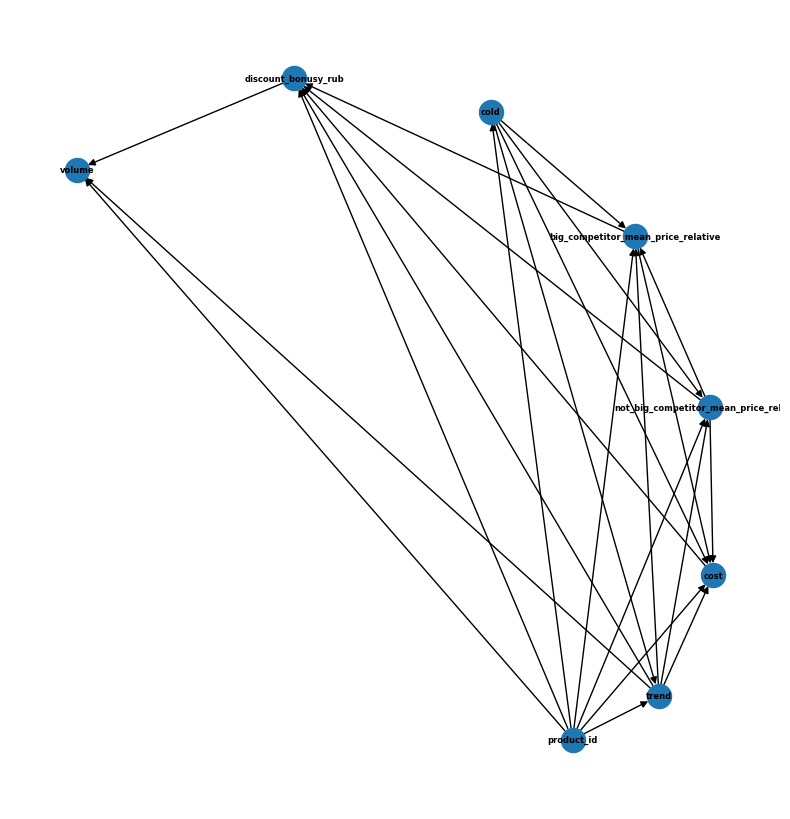

In [274]:
plot_graph(bn22.edges)

In [63]:
bn22.fit_parameters(df2[predictors+target])

In [64]:
val_pred22 = bn22.predict(df2[predictors], 5)

100%|██████████| 93395/93395 [02:58<00:00, 524.59it/s]


### Results

<Figure size 640x480 with 0 Axes>

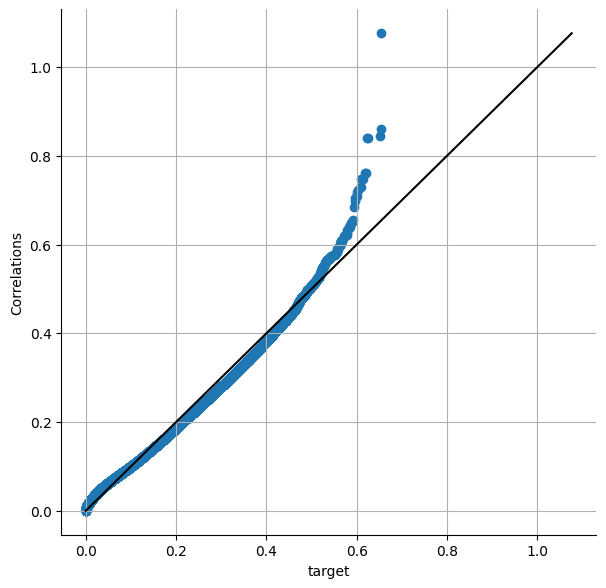

<Figure size 640x480 with 0 Axes>

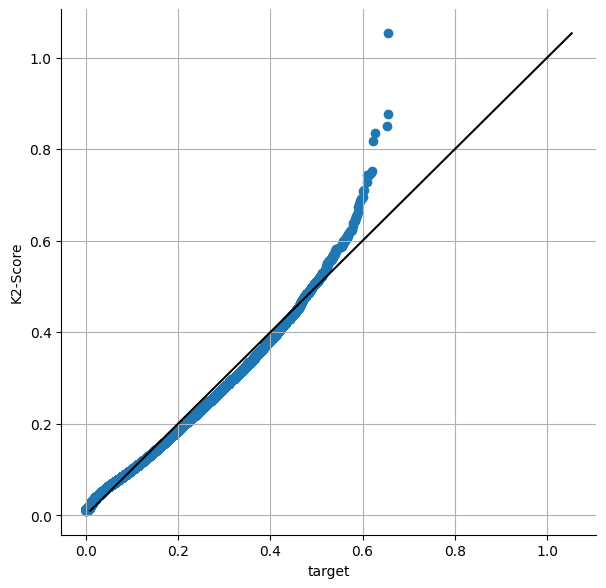

,Correlations,K2-Score
RMSE,0.044947,0.045569
MAE,0.032382,0.032881
R2,0.793126,0.787362


In [65]:
dfeval2, dfscores2= eval(df2, 'volume', [val_pred21, val_pred22], labels=['Correlations','K2-Score'])
dfscores2

## Target = profit

### Preprocessing

In [275]:
target = ["profit"]
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
p3 = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p3.apply(df[predictors+target])
info3 = p3.info
info3

{'types': {'product_id': 'disc',
  'cold': 'disc',
  'cost': 'cont',
  'trend': 'cont',
  'discount_bonusy_rub': 'cont',
  'big_competitor_mean_price_relative': 'cont',
  'not_big_competitor_mean_price_relative': 'cont',
  'profit': 'cont'},
 'signs': {'cost': 'pos',
  'trend': 'pos',
  'discount_bonusy_rub': 'pos',
  'big_competitor_mean_price_relative': 'pos',
  'not_big_competitor_mean_price_relative': 'pos',
  'profit': 'pos'}}

###  Learning (using correlations)

In [67]:
nodes = []
for feat in predictors+target:
    if feat in ['product_id','cold']:
        nodes.append(DiscreteNode(feat))
    else:
        nodes.append(ConditionalGaussianNode(feat))

In [68]:
bn31 = Nets.HybridBN(has_logit=False, use_mixture=False) #not working when use_mixture=True
edges = create_all_combinations(predictors+target)
bn31.set_structure(info3, nodes, edges[:])
bn31.get_info()

  0%|          | 0/7 [00:00<?, ?it/s]

,name,node_type,data_type,parents,parents_types
0,product_id,Discrete,disc,[],[]
1,cold,Discrete,disc,[product_id],[disc]
2,cost,ConditionalGaussian,cont,"[product_id, cold]","[disc, disc]"
3,trend,ConditionalGaussian,cont,"[cost, product_id, cold]","[cont, disc, disc]"
4,discount_bonusy_rub,ConditionalGaussian,cont,"[cost, trend, product_id, cold]","[cont, cont, disc, disc]"
5,big_competitor_mean_price_relative,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, product_id,...","[cont, cont, cont, disc, disc]"
6,not_big_competitor_mean_price_relative,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, big_competi...","[cont, cont, cont, cont, disc, disc]"
7,profit,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, big_competi...","[cont, cont, cont, cont, cont, disc, disc]"


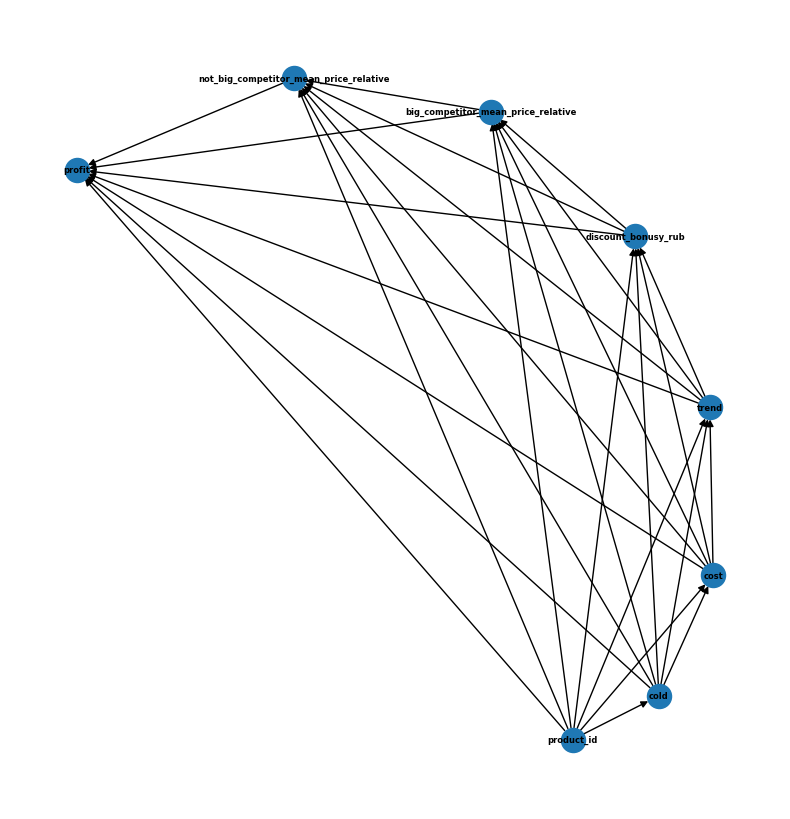

In [257]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(bn31.edges)
#pos = nx.layout.circular_layout(G_K2)
pos = nx.layout.spiral_layout(G_K2)
plt.figure(figsize=(15.4*0.5,16*0.5))
nx.draw(G_K2, pos, with_labels=True,font_weight='bold', font_size=6)

In [70]:
bn31.fit_parameters(df2[predictors+target])

In [71]:
val_pred31 = bn31.predict(df2[predictors], 5)

100%|██████████| 93395/93395 [03:02<00:00, 511.24it/s]


###  Learning (using K2-score)

In [72]:
bn32 = Nets.HybridBN()
bn32.add_nodes(info3)
bn32.add_edges(discretized_data, scoring_function=('K2',K2Score))
bn32.get_info()

  0%|          | 0/1000000 [00:00<?, ?it/s]

,name,node_type,data_type,parents,parents_types
0,product_id,Discrete,disc,[],[]
1,cold,Discrete,disc,[product_id],[disc]
2,trend,ConditionalGaussian,cont,"[product_id, cold]","[disc, disc]"
3,not_big_competitor_mean_price_relative,ConditionalGaussian,cont,"[trend, product_id, cold]","[cont, disc, disc]"
4,big_competitor_mean_price_relative,ConditionalGaussian,cont,"[trend, not_big_competitor_mean_price_relative...","[cont, cont, disc, disc]"
5,cost,ConditionalGaussian,cont,"[trend, big_competitor_mean_price_relative, no...","[cont, cont, cont, disc, disc]"
6,discount_bonusy_rub,ConditionalGaussian,cont,"[cost, trend, big_competitor_mean_price_relati...","[cont, cont, cont, cont, disc]"
7,profit,ConditionalGaussian,cont,"[cost, trend, discount_bonusy_rub, product_id]","[cont, cont, cont, disc]"


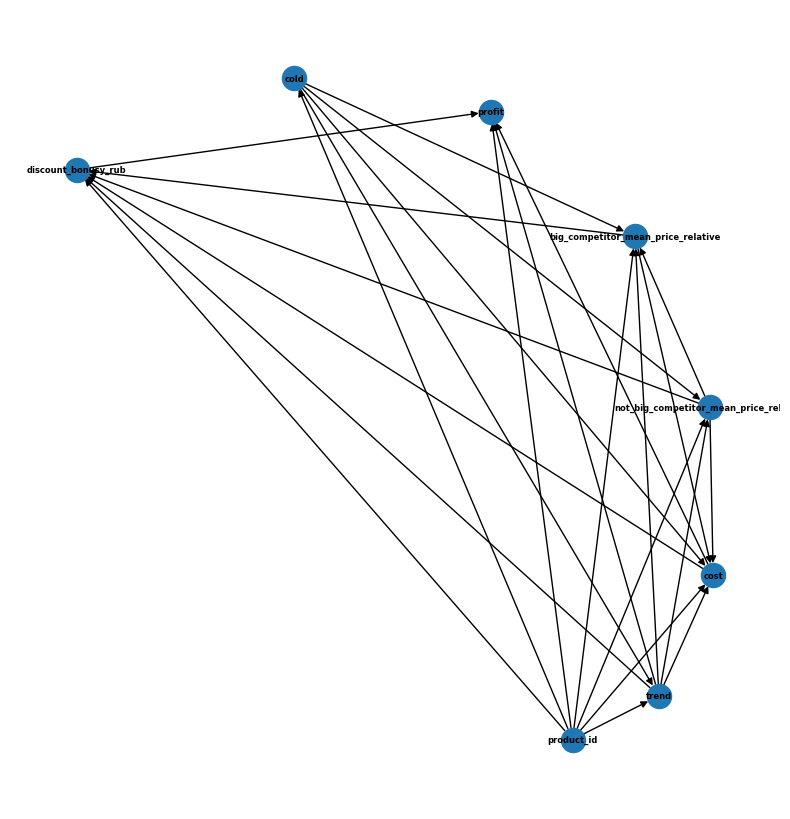

In [276]:
plot_graph(bn32.edges)

In [74]:
bn32.fit_parameters(df2[predictors+target])

In [75]:
val_pred32 = bn32.predict(df2[predictors], 5)

100%|██████████| 93395/93395 [02:50<00:00, 547.81it/s]


### Results

<Figure size 640x480 with 0 Axes>

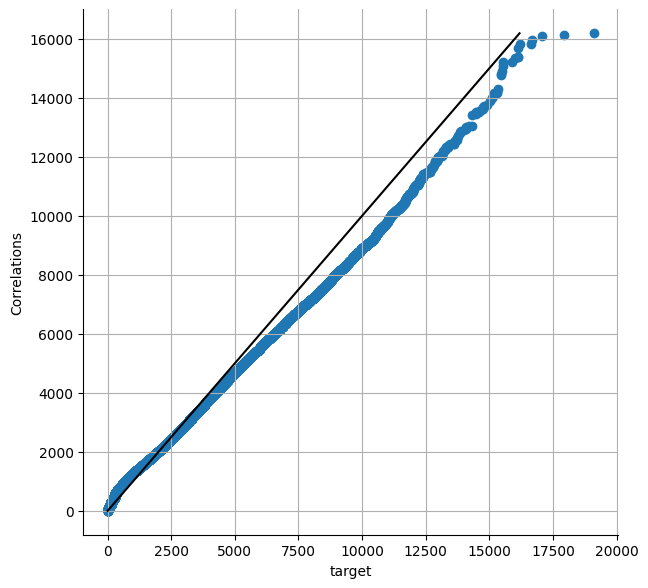

<Figure size 640x480 with 0 Axes>

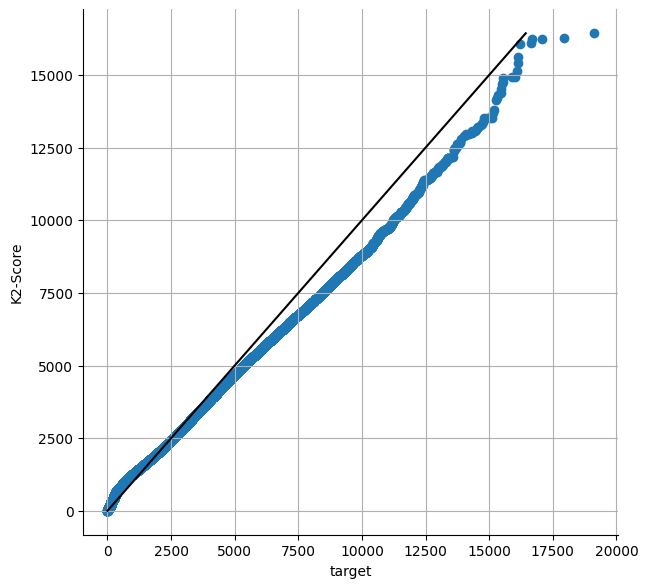

,Correlations,K2-Score
RMSE,972.318103,987.97272
MAE,680.335259,694.646425
R2,0.758362,0.750518


In [77]:
dfeval3, dfscores3= eval(df2, 'profit', [val_pred31, val_pred32], labels=['Correlations','K2-Score'])
dfscores3

## Backuping results

In [81]:
tables = [dfeval, dfscores, dfeval2, dfscores2, dfeval3, dfscores3]
names = ["dfeval", "dfscores", "dfeval2", "dfscores2", "dfeval3", "dfscores3"]
for it in range(len(names)):
    tables[it].to_csv(names[it]+'.csv')